In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import ast
import json
from matplotlib import colors
from PIL import ImageColor
import glob
import matplotlib.ticker as ticker
import pathlib
import scipy.stats as st

from sklearn import preprocessing
import re

# %#config IPCompleter.greedy=True
# %#matplotlib notebook
# %#matplotlib inline
plt.rcParams["figure.figsize"] = [4, 4]

POINT_PLOT_DODGE = 0.15
sns.set(font_scale=1.25, style="ticks")
FIGSIZE = [6, 6]
# PALETTE = sns.cubehelix_palette(as_cmap=False, n_colors=3, reverse=False, light=0.7)
print("hot stuff")

hot stuff


## RQ 1.1
### Latency v Number of users, no congestion

### Flow Statistics

In [2]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Flow Statistics"
EXPERIMENT = "e1_1"

e1_1_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        # print(label)
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Experiment"] = label[-3]

        # label_list = label.split("_")

        e1_1_df = pd.concat([e1_1_df, t_df])

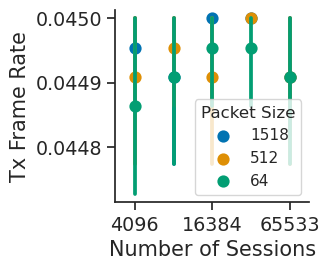

In [3]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[2.5, 2.5])

p_df = e1_1_df[e1_1_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

sns.pointplot(
    data=p_df,
    x="Number of Sessions",
    # y = 'Loss %',
    y=p_df["Tx Frame Rate"] / 10**3,
    hue="Packet Size",
    ci=95,
    join=False,
    palette="colorblind",
    ax=ax1,
    hue_order=[1518, 512, 64],
)

# ax1.set_ylim([0,100])
# plt.setp(ax1.collections, alpha=.3) #for the markers
# plt.setp(ax1.lines, alpha=.5) #for the markers
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.legend(fontsize=11, title_fontsize=12, title="Packet Size")
sns.despine()
# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_1_loss.pdf", bbox_inches='tight')

### Latency bins

In [53]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Latency Bins"
EXPERIMENT = "e1_1"

bins_e1_1_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        # print(label)
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Experiment"] = label[-3]

        # label_list = label.split("_")

        bins_e1_1_df = pd.concat([bins_e1_1_df, t_df])

In [54]:
# Only get the latency probe stream
p_df = bins_e1_1_df[bins_e1_1_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Number of Sessions"], right_index=True, left_index=True
)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_df = p_temp_df.drop("index", axis=1)

In [7]:
# get the mean over the 10 experiments and get the cumsum
t_df = p_df.groupby(["Number of Sessions", "Packet Size"]).sum().cumsum(axis=1)

bins = list(t_df.rename(columns={"max": "170"}).columns.astype(int))

# Get the max value
max_df = t_df["max"]

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)
frequency_df = frequency_df.rename(columns={"max": "180"})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)
frequency_df.drop(labels=-4, axis=1)

# list of percentiles
percentile = [50, 99.99, 99.999]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of Sessions"] = i[0]
        t["Packet Size"] = i[1]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

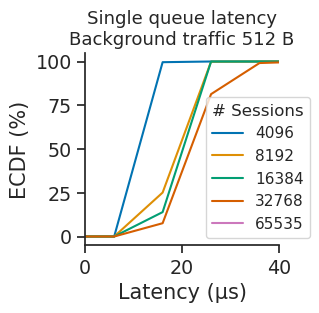

In [8]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[2.5, 2.5])

f_df = frequency_df.reset_index().drop_duplicates()
# f_df = f_df[f_df['Packet Size'] == 1518]
f_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size"],
)

f_df = f_df[f_df["Packet Size"] == 512].drop_duplicates()
sns.lineplot(
    data=f_df,
    x="variable",
    y=f_df["value"] * 100,
    hue="Number of Sessions",
    palette="colorblind",
    ax=ax1,
    hue_order=[4096, 8192, 16384, 32768, 65535],
)
ax1.set(xlabel="Latency (μs)", ylabel="ECDF (%)")
ax1.set_title(label="Single queue latency\nBackground traffic 512 B", fontsize=13)
ax1.legend(
    title="# Sessions",
    loc="lower right",
    fontsize=11,
    title_fontsize=12,
    bbox_to_anchor=(1.2, 0),
)
ax1.xaxis.set_major_locator(ticker.AutoLocator())

ax1.set_xlim([0, 40])
sns.despine()

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_1_latency_512.pdf", bbox_inches='tight')

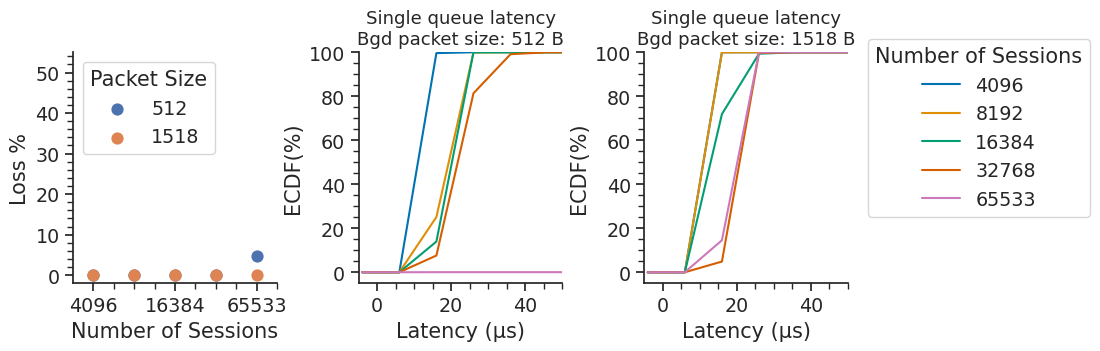

In [9]:
fig, ax1 = plt.subplots(nrows=1, ncols=3, figsize=[10, 3])

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size"],
)

# Ensure "Number of Sessions" is categorical
# t_df["Number of Sessions"] = t_df["Number of Sessions"].astype("category")
t_df = t_df[(t_df["Number of Sessions"] >= 4096.0)]

PACKET_SIZE = [512, 1518]
OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 1

loss_df = e1_1_df[e1_1_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]
loss_df = loss_df[(loss_df["Number of Sessions"] >= 4096.0)]
# p_df = p_df[p_df['Packet Size'] == 1518]

sns.pointplot(
    data=loss_df,
    x="Number of Sessions",
    y="Loss %",
    hue="Packet Size",
    ci=95,
    join=False,
    hue_order=[512, 1518],
    ax=ax1[0],
)
ax1[0].legend(title="Packet Size", loc="upper left")
ax1[0].xaxis.set_major_locator(ticker.AutoLocator())
ax1[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1[0].yaxis.set_major_locator(ticker.AutoLocator())
ax1[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1[0].set_ylim(-2, 55)


for j in PACKET_SIZE:
    f_df = t_df[t_df["Packet Size"] == j].drop_duplicates()
    # if not f_df[f_df["Offered Load"] == "20gbps"].empty:
    sns.lineplot(
        data=f_df,
        x="variable",
        y=f_df["value"] * 100,
        hue="Number of Sessions",
        palette="colorblind",
        ax=ax1[j_cnt],
    )

    ax1[1].get_legend().remove()
    ax1[j_cnt].set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
    ax1[j_cnt].legend(
        title="Number of Sessions", loc="upper left", bbox_to_anchor=(1.05, 1.1)
    )
    ax1[j_cnt].set_title(
        label=f"Single queue latency\nBgd packet size: {PACKET_SIZE[j_cnt-1]} B",
        fontsize=13,
    )
    ax1[j_cnt].set_ylim(-5, 100)
    ax1[j_cnt].set_xlim(-5, 50)
    # ax1[i_cnt][j_cnt].set_xlim(0, 50)
    ax1[j_cnt].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[j_cnt].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].yaxis.set_minor_locator(ticker.AutoMinorLocator())

    sns.despine()

    j_cnt += 1
# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_1.pdf", bbox_inches='tight')

## RQ 1.2
### Latency v Number of users, congestion
### Flow Statistics

In [10]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Flow Statistics"
EXPERIMENT = "e1_2"

e1_2_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        # print(label)
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Experiment"] = label[-3]

        # label_list = label.split("_")

        e1_2_df = pd.concat([e1_2_df, t_df])

In [11]:
e1_2_df.columns

Index(['Tx Port', 'Rx Port', 'Traffic Item', 'Flow Group', 'Tx Frames',
       'Rx Frames', 'Frames Delta', 'Loss %', 'Tx Frame Rate', 'Rx Frame Rate',
       'Tx L1 Rate (bps)', 'Rx L1 Rate (bps)', 'Rx Bytes', 'Tx Rate (Bps)',
       'Rx Rate (Bps)', 'Tx Rate (bps)', 'Rx Rate (bps)', 'Tx Rate (Kbps)',
       'Rx Rate (Kbps)', 'Tx Rate (Mbps)', 'Rx Rate (Mbps)',
       'Cut-Through Avg Latency (ns)', 'Cut-Through Min Latency (ns)',
       'Cut-Through Max Latency (ns)', 'First TimeStamp', 'Last TimeStamp',
       'Packet Size', 'Number of Sessions', 'Experiment'],
      dtype='object')

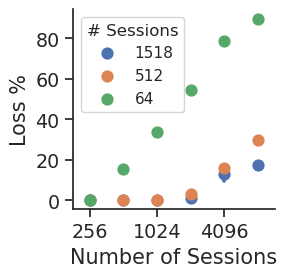

In [12]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[2.6, 2.6])

p_df = e1_2_df[e1_2_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

sns.pointplot(
    data=p_df,
    x="Number of Sessions",
    y="Loss %",
    # y=p_df["Cut-Through Avg Latency (ns)"] / 10**3,
    hue="Packet Size",
    ci=95,
    join=False,
    ax=ax1,
    hue_order=[1518, 512, 64],
)

# ax1.set(xlabel="Latency (μs)", ylabel="ECDF (%)")
# ax1.set_title(label='Single queue latency\nBackground traffic 1518 B',fontsize=13)
ax1.legend(
    title="# Sessions", loc="upper left", fontsize=11, title_fontsize=12
)  # ,bbox_to_anchor=(1.2, 0))
ax1.xaxis.set_major_locator(ticker.AutoLocator())
# ax1.set_xlim([0, 40])
sns.despine()

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_2_loss.pdf", bbox_inches='tight')

In [13]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


### Latency Bins

In [58]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Latency Bins"
EXPERIMENT = "e1_2"

bins_e1_2_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        # print(label)
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Experiment"] = label[-3]

        # label_list = label.split("_")

        bins_e1_2_df = pd.concat([bins_e1_2_df, t_df])

In [59]:
# Only get the latency probe stream
p_df = bins_e1_2_df[bins_e1_2_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Number of Sessions"], right_index=True, left_index=True
)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_df = p_temp_df.drop("index", axis=1)

In [61]:
# get the mean over the 10 experiments and get the cumsum
t_df = p_df.groupby(["Number of Sessions", "Packet Size"]).sum().cumsum(axis=1)

# Get the max value
max_df = t_df["max"]

bins = list(t_df.rename(columns={"max": "800"}).columns.astype(int))

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)

# Columns to int, and subtract the propagation delay
frequency_df = frequency_df.rename(columns={"max": "800"})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)
# frequency_df.drop(labels=-4,axis=1)

# list of percentiles
percentile = [50, 75, 99.99, 99.999]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of Sessions"] = i[0]
        t["Packet Size"] = i[1]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

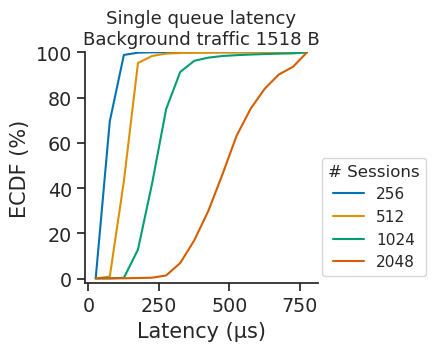

In [18]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])

f_df = frequency_df.reset_index().drop_duplicates()
# f_df = f_df[f_df['Packet Size'] == 1518]
f_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size"],
)

f_df = f_df[f_df["Packet Size"] == 1518].drop_duplicates()
sns.lineplot(
    data=f_df,
    x="variable",
    y=f_df["value"] * 100,
    hue="Number of Sessions",
    palette="colorblind",
    ax=ax1,
    hue_order=[256, 512, 1024, 2048],
)

ax1.set(xlabel="Latency (μs)", ylabel="ECDF (%)")
ax1.set_title(label="Single queue latency\nBackground traffic 1518 B", fontsize=13)
ax1.legend(
    title="# Sessions",
    loc="lower right",
    fontsize=11,
    title_fontsize=12,
    bbox_to_anchor=(1.5, 0),
)
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.set_ylim([-2, 100])
sns.despine()

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_2_latency.pdf", bbox_inches='tight')

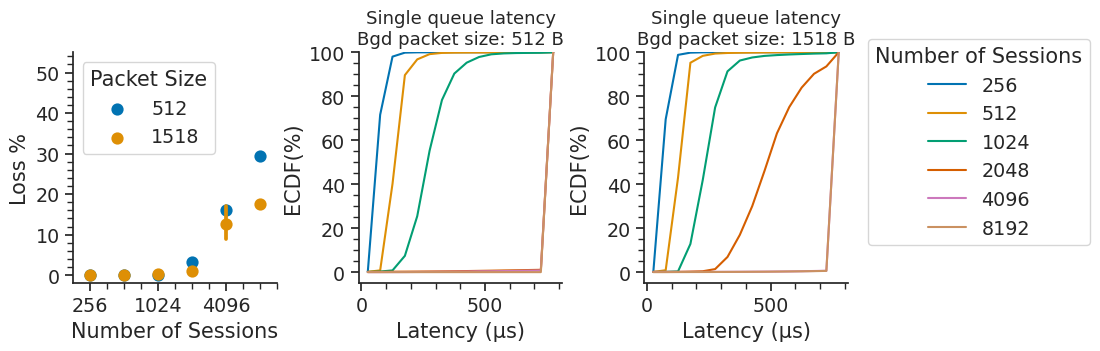

In [19]:
fig, ax1 = plt.subplots(nrows=1, ncols=3, figsize=[10, 3], dpi=100)

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size"],
)

# Ensure "Number of Sessions" is categorical
# t_df["Number of Sessions"] = t_df["Number of Sessions"].astype("category")
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "50gbps")]
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"].isin(["50gbps", "20gbps"]))]

PACKET_SIZE = [512, 1518]
# OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 1

loss_df = e1_2_df[e1_2_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]
# p_df = p_df[p_df['Packet Size'] == 1518]

sns.pointplot(
    data=loss_df,
    x="Number of Sessions",
    y="Loss %",
    hue="Packet Size",
    ci=95,
    join=False,
    hue_order=[512, 1518],
    palette="colorblind",
    ax=ax1[0],
)
ax1[0].legend(title="Packet Size", loc="upper left")
ax1[0].xaxis.set_major_locator(ticker.AutoLocator())
ax1[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1[0].yaxis.set_major_locator(ticker.AutoLocator())
ax1[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1[0].set_ylim(-2, 55)

for j in PACKET_SIZE:
    f_df = t_df[t_df["Packet Size"] == j].drop_duplicates()
    sns.lineplot(
        data=f_df,
        x="variable",
        y=f_df["value"] * 100,
        hue="Number of Sessions",
        palette="colorblind",
        # style="Offered Load",
        ax=ax1[j_cnt],
    )

    ax1[1].get_legend().remove()
    ax1[j_cnt].set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
    ax1[j_cnt].legend(
        loc="upper left", bbox_to_anchor=(1.05, 1.1), title="Number of Sessions"
    )
    ax1[j_cnt].set_title(
        label=f"Single queue latency\nBgd packet size: {PACKET_SIZE[j_cnt-1]} B",
        fontsize=13,
    )
    ax1[j_cnt].set_ylim(-5, 100)
    # ax1[j_cnt].set_xlim(-5, 150)
    # ax1[i_cnt][j_cnt].set_xlim(0, 50)
    ax1[j_cnt].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[j_cnt].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].yaxis.set_minor_locator(ticker.AutoMinorLocator())

    sns.despine()

    j_cnt += 1
# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_2.pdf", bbox_inches='tight')

## RQ 1.3
#### Loss %

In [20]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Flow Statistics"
EXPERIMENT = "e1_3"

e1_3_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        # print(label)
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Experiment"] = label[-3]

        # label_list = label.split("_")

        e1_3_df = pd.concat([e1_3_df, t_df])

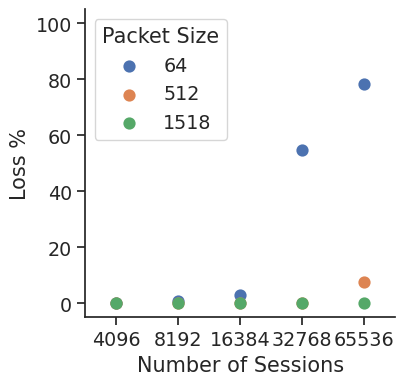

In [21]:
p_df = e1_3_df[e1_3_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

fig = sns.pointplot(
    data=p_df,
    x="Number of Sessions",
    y="Loss %",
    # y=p_df["Cut-Through Avg Latency (ns)"] / 10**3 - 24,
    hue="Packet Size",
    ci=95,
    join=False,
)

# fig.set_ylabel("Avg Latency (us)")
fig.set_ylim([-5, 105])

sns.despine()

### Latency Bins

In [67]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Latency Bins"
EXPERIMENT = "e1_3/"

bins_e1_3_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")

        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Experiment"] = label[-3]

        bins_e1_3_df = pd.concat([bins_e1_3_df, t_df])

In [68]:
# Only get the latency probe stream
p_df = bins_e1_3_df[bins_e1_3_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Number of Sessions"], right_index=True, left_index=True
)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_df = p_temp_df.drop("index", axis=1)

# get the sum over the 10 experiments and get the cumsum
t_df = pd.DataFrame()
t_df = p_df.groupby(["Number of Sessions", "Packet Size", "Experiment"]).sum().cumsum(axis=1)

# Get the max value
max_df = t_df["max"]

bins = list(t_df.rename(columns={"max": "180"}).columns.astype(int))

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)

# Columns to int, and subtract the propagation delay
frequency_df = frequency_df.rename(columns={"max": "180"})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)
# frequency_df.drop(labels=-4,axis=1)

# list of percentiles
percentile = [50, 75, 99.99, 99.999]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of Sessions"] = i[0]
        t["Packet Size"] = i[1]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

/tmp/ipykernel_28413/2239522713.py:68: RuntimeWarning: invalid value encountered in scalar divide
  value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (


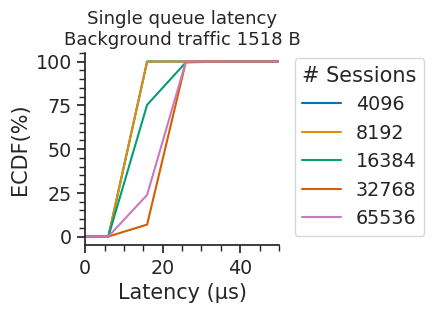

In [24]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[2.5, 2.5])

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
f_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size"],
)

f_df = f_df[f_df["Packet Size"] == 1518].drop_duplicates()
sns.lineplot(
    data=f_df,
    x="variable",
    y=f_df["value"] * 100,
    hue="Number of Sessions",
    palette="colorblind",
    ax=ax1,
)

ax1.set(xlabel="Latency (µs)", ylabel="ECDF(%)")
ax1.legend(title="# Sessions", loc="lower right", bbox_to_anchor=(1.8, 0))
ax1.set_title(label="Single queue latency\nBackground traffic 1518 B", fontsize=13)
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.set_ylim(-5, 105)
ax1.set_xlim(0, 50)
sns.despine()

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_3_latency.pdf", bbox_inches='tight')

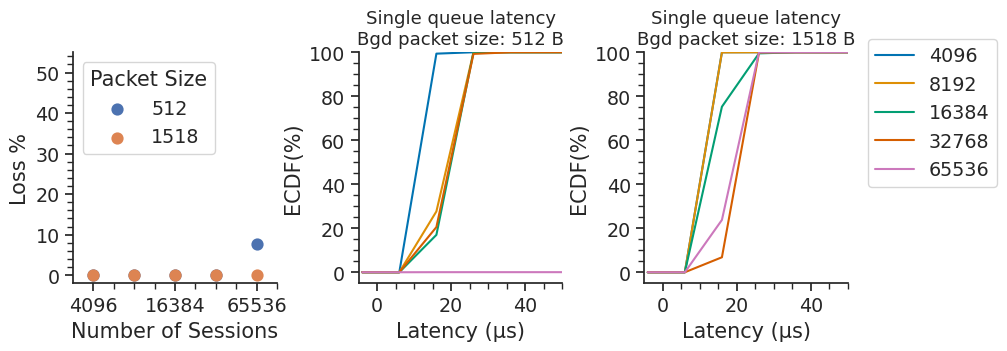

In [25]:
fig, ax1 = plt.subplots(nrows=1, ncols=3, figsize=[10, 3])

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size"],
)

# Ensure "Number of Sessions" is categorical
# t_df["Number of Sessions"] = t_df["Number of Sessions"].astype("category")
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "50gbps")]
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"].isin(["50gbps", "20gbps"]))]

PACKET_SIZE = [512, 1518]
# OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 1

loss_df = e1_3_df[e1_3_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]
# p_df = p_df[p_df['Packet Size'] == 1518]

sns.pointplot(
    data=loss_df,
    x="Number of Sessions",
    y="Loss %",
    hue="Packet Size",
    ci=95,
    join=False,
    hue_order=[512, 1518],
    ax=ax1[0],
)
ax1[0].legend(title="Packet Size", loc="upper left")
ax1[0].xaxis.set_major_locator(ticker.AutoLocator())
ax1[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1[0].yaxis.set_major_locator(ticker.AutoLocator())
ax1[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1[0].set_ylim(-2, 55)

for j in PACKET_SIZE:
    f_df = t_df[t_df["Packet Size"] == j].drop_duplicates()
    sns.lineplot(
        data=f_df,
        x="variable",
        y=f_df["value"] * 100,
        hue="Number of Sessions",
        palette="colorblind",
        # style="Offered Load",
        ax=ax1[j_cnt],
    )

    ax1[1].get_legend().remove()
    ax1[j_cnt].set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
    ax1[j_cnt].legend(loc="upper left", bbox_to_anchor=(1.05, 1.1))
    ax1[j_cnt].set_title(
        label=f"Single queue latency\nBgd packet size: {PACKET_SIZE[j_cnt-1]} B",
        fontsize=13,
    )
    ax1[j_cnt].set_ylim(-5, 100)
    ax1[j_cnt].set_xlim(-5, 50)
    # ax1[i_cnt][j_cnt].set_xlim(0, 50)
    ax1[j_cnt].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[j_cnt].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].yaxis.set_minor_locator(ticker.AutoMinorLocator())

    sns.despine()

    j_cnt += 1
# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_3.pdf", bbox_inches='tight')

## RQ 1.4
### Loss %

In [69]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Flow Statistics"
EXPERIMENT = "e1_4/"

e1_4_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc or "old" in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")

        t_df = pd.read_csv(direc + "/" + i)
        t_df["Offered Load"] = label[-3]
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Packet Size"] = int(label[-1])
        t_df["Experiment"] = label[-4]

        e1_4_df = pd.concat([e1_4_df, t_df])

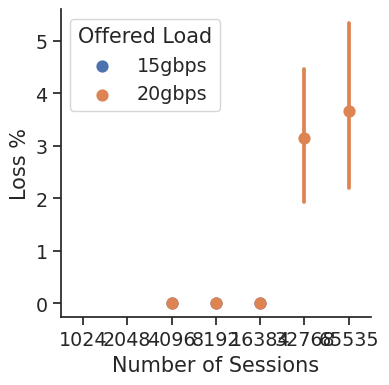

In [27]:
p_df = e1_4_df[e1_4_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]
# p_df = p_df[p_df['Packet Size'] == 1518]

fig = sns.pointplot(
    data=p_df,
    x="Number of Sessions",
    y="Loss %",
    hue="Offered Load",
    ci=95,
    join=False,
    hue_order=["15gbps", "20gbps"],
)

# fig.set_ylabel("Avg Latency (us)")
# fig.set_ylim([-0.2, 150])

sns.despine()

### Latency bins

In [71]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Latency Bins"
EXPERIMENT = "e1_4/"

bins_e1_4_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")

        t_df = pd.read_csv(direc + "/" + i)
        t_df["Offered Load"] = label[-3]
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Packet Size"] = int(label[-1])
        t_df["Experiment"] = label[-4]

        bins_e1_4_df = pd.concat([bins_e1_4_df, t_df])

In [74]:
# Only get the latency probe stream
p_df = bins_e1_4_df[bins_e1_4_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Number of Sessions"], right_index=True, left_index=True
)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(p_df["Offered Load"], right_index=True, left_index=True)
p_df = p_temp_df.drop("index", axis=1)

# get the sum over the 10 experiments and get the cumsum
t_df = pd.DataFrame()
t_df = (
    p_df.groupby(["Number of Sessions", "Packet Size", "Offered Load", "Experiment"])
    .sum()
    .cumsum(axis=1)
)

# Get the max value
max_df = t_df["max"]

bins = list(t_df.rename(columns={"max": 170}).columns.astype(int))

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)

# Columns to int, and subtract the propagation delay
frequency_df = frequency_df.rename(columns={"max": "160"})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)
# frequency_df.drop(labels=-4,axis=1)

# list of percentiles
percentile = [2]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of Sessions"] = i[0]
        t["Packet Size"] = i[1]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

/tmp/ipykernel_28413/3682137908.py:73: RuntimeWarning: invalid value encountered in scalar divide
  value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (


In [30]:
pd.DataFrame(percentile_lst)

,percentile,Number of Sessions,Packet Size,Value
0,2,4096,512,44.9616
1,2,4096,1518,30.8296
2,2,8192,512,51.1120
3,2,8192,1518,31.0323
4,2,16384,512,71.7760
5,2,16384,1518,31.4307
6,2,32768,512,160.1946
7,2,32768,1518,31.4786
8,2,65535,512,160.1961
9,2,65535,1518,31.5047


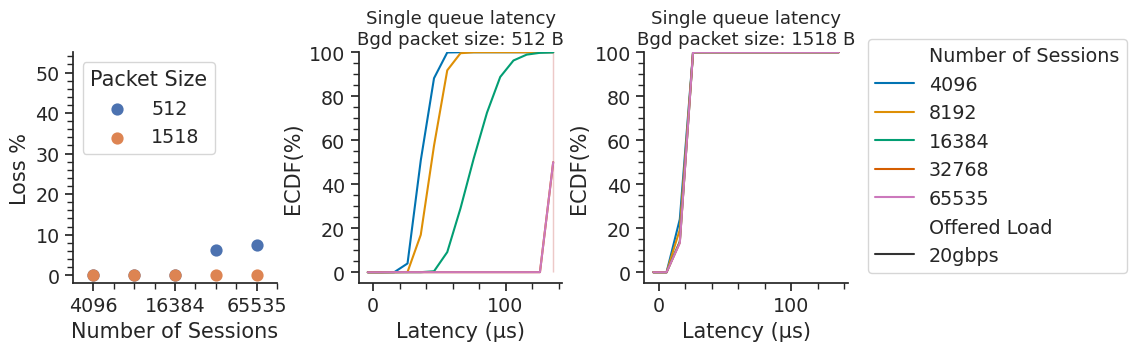

In [31]:
fig, ax1 = plt.subplots(nrows=1, ncols=3, figsize=[10, 3])

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size", "Offered Load"],
)

# Ensure "Number of Sessions" is categorical
# t_df["Number of Sessions"] = t_df["Number of Sessions"].astype("category")
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "50gbps")]
t_df = t_df[
    (t_df["Number of Sessions"] >= 4096.0)
    & (t_df["Offered Load"].isin(["50gbps", "20gbps"]))
]

PACKET_SIZE = [512, 1518]
OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 1

loss_df = e1_4_df[e1_4_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]
# p_df = p_df[p_df['Packet Size'] == 1518]

sns.pointplot(
    data=loss_df[loss_df["Offered Load"] == "20gbps"],
    x="Number of Sessions",
    y="Loss %",
    hue="Packet Size",
    ci=95,
    join=False,
    # hue_order=["15gbps", "20gbps", "25gbps", "50gbps"],
    ax=ax1[0],
)
ax1[0].legend(title="Packet Size", loc="upper left")
ax1[0].xaxis.set_major_locator(ticker.AutoLocator())
ax1[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1[0].yaxis.set_major_locator(ticker.AutoLocator())
ax1[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1[0].set_ylim(-2, 55)


for j in PACKET_SIZE:
    f_df = t_df[t_df["Packet Size"] == j].drop_duplicates()
    sns.lineplot(
        data=f_df,
        x="variable",
        y=f_df["value"] * 100,
        hue="Number of Sessions",
        palette="colorblind",
        style="Offered Load",
        ax=ax1[j_cnt],
    )

    ax1[1].get_legend().remove()
    ax1[j_cnt].set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
    ax1[j_cnt].legend(loc="upper left", bbox_to_anchor=(1.05, 1.1))
    ax1[j_cnt].set_title(
        label=f"Single queue latency\nBgd packet size: {PACKET_SIZE[j_cnt-1]} B",
        fontsize=13,
    )
    ax1[j_cnt].set_ylim(-5, 100)
    # ax1[j_cnt].set_xlim(-5, 150)
    # ax1[i_cnt][j_cnt].set_xlim(0, 50)
    ax1[j_cnt].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[j_cnt].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].yaxis.set_minor_locator(ticker.AutoMinorLocator())

    sns.despine()

    j_cnt += 1
# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_4.pdf", bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


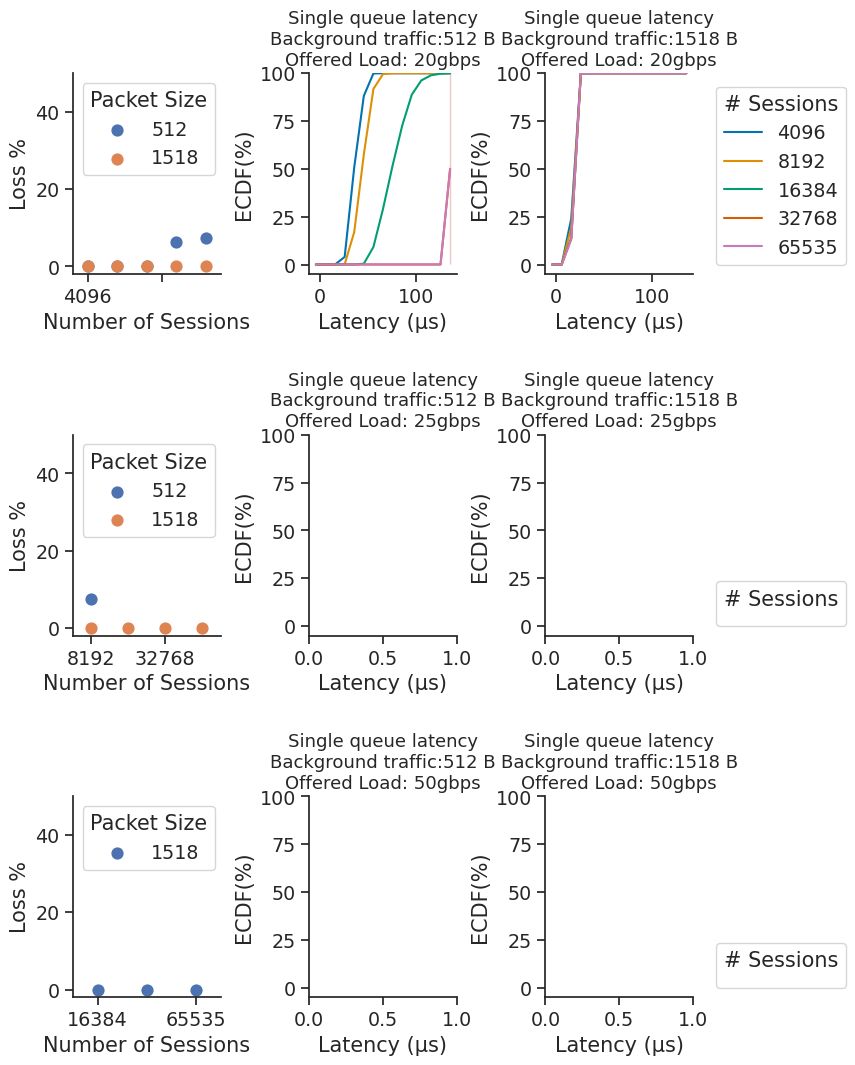

In [32]:
fig, ax1 = plt.subplots(nrows=3, ncols=3, figsize=[8, 12])

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size", "Offered Load"],
)
f_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "20gbps")]

PACKET_SIZE = [512, 1518]
OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 1

loss_df = e1_4_df[e1_4_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]
# p_df = p_df[p_df['Packet Size'] == 1518]

for i in OFFERED_LOAD:
    j_cnt = 1
    sns.pointplot(
        data=loss_df[loss_df["Offered Load"] == i],
        x="Number of Sessions",
        y="Loss %",
        hue="Packet Size",
        ci=95,
        join=False,
        # hue_order=["15gbps", "20gbps", "25gbps", "50gbps"],
        ax=ax1[i_cnt][0],
    )
    ax1[i_cnt][0].legend(title="Packet Size", loc="upper left")
    ax1[i_cnt][0].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[i_cnt][0].set_ylim(-2, 50)

    for j in PACKET_SIZE:
        f_df = t_df[t_df["Packet Size"] == j].drop_duplicates()
        if not f_df[f_df["Offered Load"] == i].empty:
            sns.lineplot(
                data=f_df[f_df["Offered Load"] == i],
                x="variable",
                y=f_df["value"] * 100,
                hue="Number of Sessions",
                palette="colorblind",
                ax=ax1[i_cnt][j_cnt],
            )

        if ax1[i_cnt][1].get_legend() != None:
            ax1[i_cnt][1].get_legend().remove()
        ax1[i_cnt][j_cnt].set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
        ax1[i_cnt][j_cnt].legend(
            title="# Sessions", loc="lower right", bbox_to_anchor=(2.1, 0)
        )
        ax1[i_cnt][j_cnt].set_title(
            label=f"Single queue latency\nBackground traffic:{j} B\nOffered Load: {i}",
            fontsize=13,
        )
        ax1[i_cnt][j_cnt].set_ylim(-5, 100)
        # ax1[i_cnt][j_cnt].set_xlim(0, 50)
        ax1[j_cnt][j_cnt].xaxis.set_major_locator(ticker.AutoLocator())
        sns.despine()

        j_cnt += 1
    i_cnt += 1
# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.6)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_4.pdf", bbox_inches='tight')

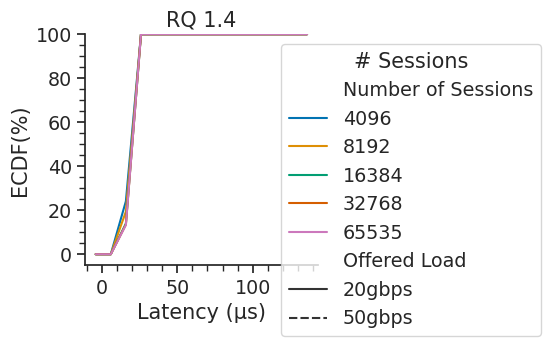

In [33]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size", "Offered Load"],
)
f_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "20gbps")]

PACKET_SIZE = [512, 1518]
OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 1

loss_df = e1_4_df[e1_4_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]
# p_df = p_df[p_df['Packet Size'] == 1518]

# { PLOT11
f_df = t_df[t_df["Packet Size"] == 1518].drop_duplicates()
sns.lineplot(
    data=f_df,
    x="variable",
    y=f_df["value"] * 100,
    style="Offered Load",
    style_order=["20gbps", "50gbps"],
    hue="Number of Sessions",
    palette="colorblind",
    ax=ax1,
)
ax1.set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
ax1.legend(title="# Sessions", loc="upper right", bbox_to_anchor=(2, 1))
ax1.set_title(label=f"RQ 1.4")
# ax1[1][1].set_title(
#    label=f"Single queue latency\nBgd packet size: {PACKET_SIZE[j_cnt-1]} B\nOffered Load: 20 Gbps",
#    fontsize=13,
# )
ax1.set_ylim(-5, 100)
# ax1[1].set_xlim(0, 50)
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
# } /PLOT11

sns.despine()

j_cnt += 1
# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.5, wspace=0.6)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e1_4_50gbps.pdf", bbox_inches='tight')

### E 2.1 - No congestion

In [34]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Flow Statistics"
EXPERIMENT = "e2_1/"

e2_1_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        # print(label)
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of TC"] = int(label[-2])
        t_df["Experiment"] = label[-3]

        # label_list = label.split("_")

        e2_1_df = pd.concat([e2_1_df, t_df])

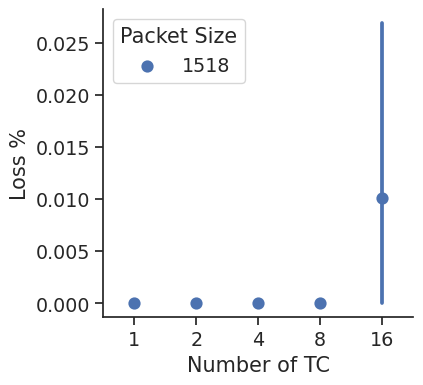

In [35]:
p_df = e2_1_df[e2_1_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

fig = sns.pointplot(
    data=p_df,
    x="Number of TC",
    y="Loss %",
    # y=p_df["Cut-Through Avg Latency (ns)"] / 10**3 - 24,
    hue="Packet Size",
    ci=95,
    join=False,
)

# fig.set_ylabel("Avg Latency (us)")
# fig.set_ylim([-0.2, i])

sns.despine()

### Latency bins

In [80]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Latency Bins"
EXPERIMENT = "e2_1/"

bins_e2_1_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")

        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of TC"] = int(label[-2])
        t_df["Experiment"] = label[-3]

        bins_e2_1_df = pd.concat([bins_e2_1_df, t_df])

In [81]:
# Only get the latency probe stream
p_df = bins_e2_1_df[bins_e2_1_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(p_df["Number of TC"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_df = p_temp_df.drop("index", axis=1)

# get the sum over the 10 experiments and get the cumsum
t_df = pd.DataFrame()
t_df = p_df.groupby(["Number of TC", "Packet Size"]).sum().cumsum(axis=1)



# Get the max value
max_df = t_df["max"]

bins = list(t_df.rename(columns={"max": 170}).columns.astype(int))

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)

# Columns to int, and subtract the propagation delay
frequency_df = frequency_df.rename(columns={"max": 170})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)
# frequency_df.drop(labels=-4,axis=1)

# list of percentiles
percentile = [50, 75, 99.99, 99.999]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of Sessions"] = i[0]
        t["Packet Size"] = i[1]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

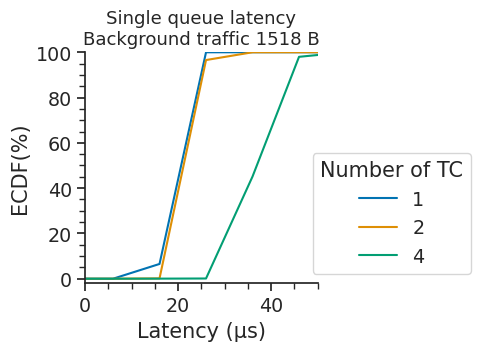

In [82]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
f_df = f_df.melt(
    id_vars=["Number of TC", "Packet Size"],
)

f_df = f_df[f_df["Packet Size"] == 1518].drop_duplicates()
sns.lineplot(
    data=f_df,
    x="variable",
    y=f_df["value"] * 100,
    hue="Number of TC",
    palette="colorblind",
    ax=ax1,
    hue_order=[1, 2, 4],
)

ax1.set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
ax1.legend(title="Number of TC", loc="lower right", bbox_to_anchor=(1.7, 0))
ax1.set_title(label="Single queue latency\nBackground traffic 1518 B", fontsize=13)
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.set_ylim(-2, 100)
ax1.set_xlim(-0, 50)
sns.despine()

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e2_1_65kusers_latency.pdf", bbox_inches='tight')

## RQ 2.2
### Latency v Traffic classes, congestion
### Flow Statistics

In [39]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Flow Statistics"
EXPERIMENT = "e2_2/512_v2"

e2_2_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        # print(label)
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of TC"] = int(label[-2])
        t_df["Experiment"] = label[-3]

        # label_list = label.split("_")

        e2_2_df = pd.concat([e2_2_df, t_df])

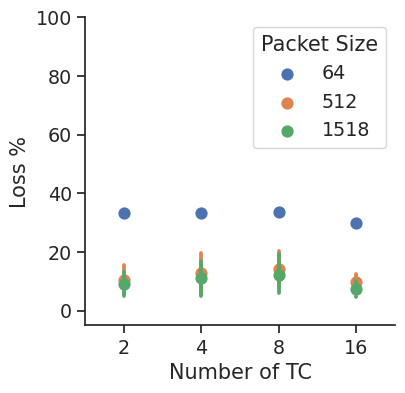

In [40]:
# p_df = e2_2_df[e2_2_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

fig = sns.pointplot(
    data=e2_2_df,
    x="Number of TC",
    y="Loss %",
    # y=p_df["Cut-Through Avg Latency (ns)"] / 10**3 - 24,
    hue="Packet Size",
    ci=95,
    join=False,
)

# fig.set_ylabel("Avg Latency (us)")
fig.set_ylim([-5, 100])

sns.despine()

<Axes: xlabel='Number of TC', ylabel='Tx L1 Rate (bps)'>

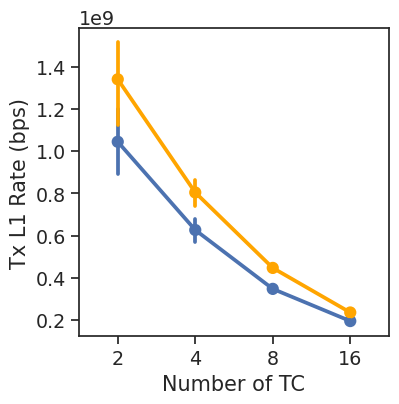

In [41]:
sns.pointplot(
    data=e2_2_df,
    x="Number of TC",
    y="Rx L1 Rate (bps)",
)
sns.pointplot(data=e2_2_df, x="Number of TC", y="Tx L1 Rate (bps)", color="orange")

### Bins

In [101]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Latency Bins"
EXPERIMENT = "e2_2/512_v2"

bins_e2_2_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        # print(label)
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of TC"] = int(label[-2])
        t_df["Experiment"] = label[-3]

        # label_list = label.split("_")

        bins_e2_2_df = pd.concat([bins_e2_2_df, t_df])

In [104]:
# Only get the latency probe stream
p_df = bins_e2_2_df[bins_e2_2_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(p_df["Number of TC"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_df = p_temp_df.drop("index", axis=1)

# get the mean over the 10 experiments and get the cumsum
t_df = p_df.groupby(["Number of TC", "Packet Size"]).sum().cumsum(axis=1)
t_df["0"] = 0
cols = t_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
t_df = t_df[cols]

# Get the max value
max_df = t_df["max"]

bins = list(t_df.rename(columns={"max": "800"}).columns.astype(int))

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)
frequency_df = frequency_df.rename(columns={"max": "800"})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)

# list of percentiles
percentile = [50, 75, 99.99, 99.999]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of Sessions"] = i[0]
        t["Packet Size"] = i[1]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

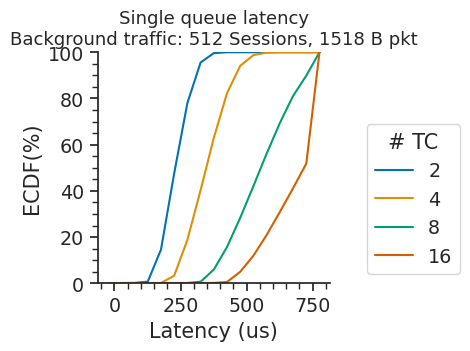

In [105]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
f_df = f_df.melt(
    id_vars=["Number of TC", "Packet Size"],
)

f_df = f_df[f_df["Packet Size"] == 1518].drop_duplicates()
sns.lineplot(
    data=f_df,
    x="variable",
    y=f_df["value"] * 100,
    hue="Number of TC",
    palette="colorblind",
    ax=ax1,
)

ax1.set(xlabel="Latency (us)", ylabel="ECDF(%)", title="RQ2.2")
ax1.legend(title="# TC", loc="lower right", bbox_to_anchor=(1.6, 0))
ax1.set_title(
    label="Single queue latency\nBackground traffic: 512 Sessions, 1518 B pkt",
    fontsize=13,
)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.set_ylim(0, 100)
sns.despine()

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e2_2.pdf", bbox_inches='tight')

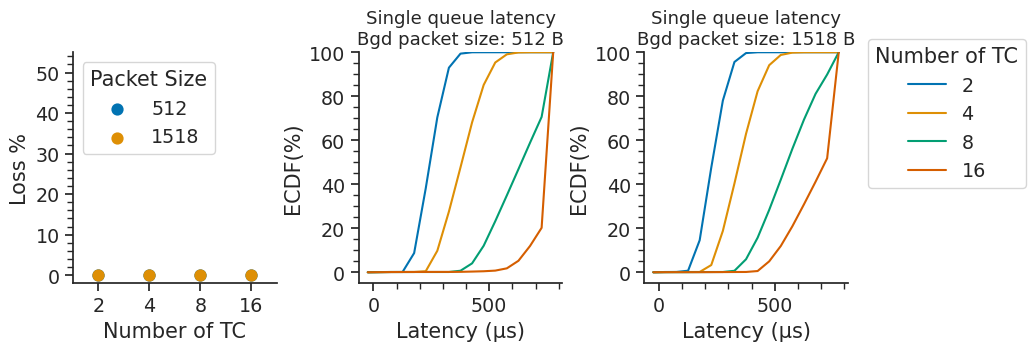

In [106]:
fig, ax1 = plt.subplots(nrows=1, ncols=3, figsize=[10, 3], dpi=100)

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of TC", "Packet Size"],
)

# Ensure "Number of Sessions" is categorical
# t_df["Number of Sessions"] = t_df["Number of Sessions"].astype("category")
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "50gbps")]
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"].isin(["50gbps", "20gbps"]))]

PACKET_SIZE = [512, 1518]
# OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 1

loss_df = e2_2_df[e2_2_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]
# p_df = p_df[p_df['Packet Size'] == 1518]

sns.pointplot(
    data=loss_df,
    x="Number of TC",
    y="Loss %",
    hue="Packet Size",
    ci=95,
    join=False,
    palette="colorblind",
    hue_order=[512, 1518],
    ax=ax1[0],
)
ax1[0].legend(title="Packet Size", loc="upper left")
# ax1[0].xaxis.set_major_locator(ticker.AutoLocator())
# ax1[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1[0].yaxis.set_major_locator(ticker.AutoLocator())
ax1[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1[0].set_ylim(-2, 55)


for j in PACKET_SIZE:
    f_df = t_df[t_df["Packet Size"] == j].drop_duplicates()
    sns.lineplot(
        data=f_df,
        x="variable",
        y=f_df["value"] * 100,
        hue="Number of TC",
        palette="colorblind",
        # style="Offered Load",
        ax=ax1[j_cnt],
    )

    ax1[1].get_legend().remove()
    ax1[j_cnt].set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
    ax1[j_cnt].legend(
        loc="upper left", bbox_to_anchor=(1.05, 1.1), title="Number of TC"
    )
    ax1[j_cnt].set_title(
        label=f"Single queue latency\nBgd packet size: {PACKET_SIZE[j_cnt-1]} B",
        fontsize=13,
    )
    ax1[j_cnt].set_ylim(-5, 100)
    # ax1[j_cnt].set_xlim(-5, 150)
    # ax1[i_cnt][j_cnt].set_xlim(0, 50)
    ax1[j_cnt].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[j_cnt].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].yaxis.set_minor_locator(ticker.AutoMinorLocator())

    sns.despine()

    j_cnt += 1
# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e2_2.pdf", bbox_inches='tight')

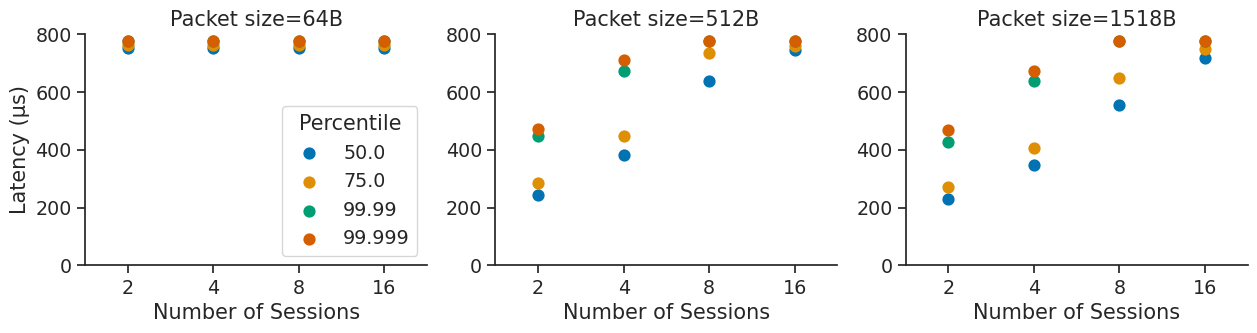

In [107]:
fig, ax1 = plt.subplots(nrows=1, ncols=3, figsize=[15, 3])

percentile_df = pd.DataFrame(percentile_lst)

pkt_sizes = [64, 512, 1518]

for i in range(0, len(pkt_sizes)):

    sns.pointplot(
        data=percentile_df[percentile_df["Packet Size"] == pkt_sizes[i]],
        x="Number of Sessions",
        y=percentile_df["Value"] - 24,
        hue="percentile",
        join=False,
        palette="colorblind",
        ax=ax1[i],
    )

    ax1[i].set(
        # xlabel="Background load (Gbps)",
        ylabel="Latency (µs)",
        # ylim=[-0.2, 50],
        title="Packet size=" + str(pkt_sizes[i]) + "B",
    )
    # ax1[i].xaxis.set_major_locator(ticker.AutoLocator())

ax1[0].set_ylim([0, 800])
ax1[1].set_ylim([0, 800])
ax1[2].set_ylim([0, 800])

ax1[1].set_ylabel("")
ax1[2].set_ylabel("")
ax1[0].legend(title="Percentile", loc="lower right")
ax1[1].legend([], [], frameon=False)
ax1[2].legend([], [], frameon=False)
sns.despine()

## RQ3
## RQ1.1

In [47]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1/e3"
FILENAME = "Latency Bins"
EXPERIMENT = "e3_1.1"

bins_e3_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Experiment"] = label[-3]
        t_df["Load Distribution"] = (
            "Load Distribution 1" if "ld1" in label[-4] else "Load Distribution 2"
        )

        # label_list = label.split("_")
        # print(label)

        bins_e3_df = pd.concat([bins_e3_df, t_df])

In [48]:
bins_e3_df
p_df = bins_e3_df[bins_e3_df["Experiment"] == "e3_1.1"]
p_df

KeyError: 'Experiment'

In [ ]:
# Only get the latency probe stream
p_df = bins_e3_df[bins_e3_df["Experiment"] == "e3_1.1"]
p_df = p_df[p_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Number of Sessions"], right_index=True, left_index=True
)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Load Distribution"], right_index=True, left_index=True
)
p_df = p_temp_df.drop("index", axis=1)

# get the mean over the 10 experiments and get the cumsum
t_df = (
    p_df.groupby(["Number of Sessions", "Packet Size", "Load Distribution"])
    .sum()
    .cumsum(axis=1)
)
t_df["0"] = 0
cols = t_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
t_df = t_df[cols]

# Get the max value
max_df = t_df["max"]

bins = list(t_df.rename(columns={"max": "170"}).columns.astype(int))

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)
frequency_df = frequency_df.rename(columns={"max": "170"})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)

# list of percentiles
percentile = [50, 75, 99.99, 99.999]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of Sessions"] = i[0]
        t["Packet Size"] = i[1]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

In [ ]:
bins_e3_df.groupby("Experiment").describe()

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])
f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
f_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size", "Load Distribution"],
)

f_df = f_df[f_df["Packet Size"] == 1518].drop_duplicates()
sns.lineplot(
    data=f_df,
    x="variable",
    y=f_df["value"] * 100,
    hue="Number of Sessions",
    style="Load Distribution",
    palette="colorblind",
    ax=ax1,
)

ax1.set(xlabel="Latency (us)", ylabel="ECDF(%)")
ax1.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax1.set_title(
    label="Single queue latency\nBackground traffic: 512 Sessions, 1518 B pkt",
    fontsize=13,
)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.set_ylim(0, 100)
ax1.set_xlim(0, 50)
sns.despine()

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e3_1.1.pdf", bbox_inches='tight')

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=[8, 3], dpi=100)

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size", "Load Distribution"],
)

# Ensure "Number of Sessions" is categorical
# t_df["Number of Sessions"] = t_df["Number of Sessions"].astype("category")
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "50gbps")]
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"].isin(["50gbps", "20gbps"]))]

PACKET_SIZE = [512, 1518]
# OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 0

for j in PACKET_SIZE:
    f_df = t_df[t_df["Packet Size"] == j].drop_duplicates()
    sns.lineplot(
        data=f_df,
        x="variable",
        y=f_df["value"] * 100,
        hue="Number of Sessions",
        palette="colorblind",
        style="Load Distribution",
        markers=True,
        markersize=8,
        style_order=["Load Distribution 1", "Load Distribution 2"],
        ax=ax1[j_cnt],
    )

    ax1[j_cnt].set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
    ax1[j_cnt].legend(
        loc="upper left", bbox_to_anchor=(1.05, 1.1), title="Number of TC"
    )
    ax1[j_cnt].set_title(
        label=f"Single queue latency\nBgd packet size: {PACKET_SIZE[j_cnt-1]} B",
        fontsize=13,
    )
    ax1[j_cnt].set_ylim(-5, 100)
    ax1[j_cnt].set_xlim(-5, 50)
    # ax1[i_cnt][j_cnt].set_xlim(0, 50)
    ax1[j_cnt].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[j_cnt].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].yaxis.set_minor_locator(ticker.AutoMinorLocator())

    sns.despine()

    j_cnt += 1
ax1[0].get_legend().remove()

# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e3_1.1.pdf", bbox_inches='tight')

### RQ 3: 1.2

In [ ]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1/e3"
FILENAME = "Latency Bins"
EXPERIMENT = "e3_1.2"

bins_e3_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Experiment"] = label[-3]
        t_df["Load Distribution"] = (
            "Load Distribution 1" if "ld1" in label[-4] else "Load Distribution 2"
        )

        # label_list = label.split("_")
        # print(label)

        bins_e3_df = pd.concat([bins_e3_df, t_df])


# Only get the latency probe stream
p_df = bins_e3_df[bins_e3_df["Experiment"] == "e3_1.2"]
p_df = p_df[p_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Number of Sessions"], right_index=True, left_index=True
)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Load Distribution"], right_index=True, left_index=True
)
p_df = p_temp_df.drop("index", axis=1)

# get the mean over the 10 experiments and get the cumsum
t_df = (
    p_df.groupby(["Number of Sessions", "Packet Size", "Load Distribution"])
    .sum()
    .cumsum(axis=1)
)
t_df["0"] = 0
cols = t_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
t_df = t_df[cols]

# Get the max value
max_df = t_df["max"]

bins = list(t_df.rename(columns={"max": "800"}).columns.astype(int))

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)
frequency_df = frequency_df.rename(columns={"max": "800"})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)

# list of percentiles
percentile = [50, 75, 99.99, 99.999]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of Sessions"] = i[0]
        t["Packet Size"] = i[1]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=[8, 3], dpi=100)

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size", "Load Distribution"],
)

# Ensure "Number of Sessions" is categorical
# t_df["Number of Sessions"] = t_df["Number of Sessions"].astype("category")
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "50gbps")]
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"].isin(["50gbps", "20gbps"]))]

PACKET_SIZE = [512, 1518]
# OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 0

for j in PACKET_SIZE:
    f_df = t_df[t_df["Packet Size"] == j].drop_duplicates()
    f_df = f_df.replace(to_replace=-24, value=0)
    sns.lineplot(
        data=f_df,
        x="variable",
        y=f_df["value"] * 100,
        hue="Number of Sessions",
        palette="colorblind",
        style="Load Distribution",
        markers=True,
        markersize=8,
        style_order=["Load Distribution 1", "Load Distribution 2"],
        ax=ax1[j_cnt],
        hue_order=[256, 512, 1024, 2048, 4096],
    )

    ax1[j_cnt].set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
    ax1[j_cnt].legend(
        loc="upper left", bbox_to_anchor=(1.05, 1.1), title="Number of TC"
    )
    ax1[j_cnt].set_title(
        label=f"Single queue latency\nBgd packet size: {PACKET_SIZE[j_cnt]} B",
        fontsize=13,
    )
    ax1[j_cnt].set_ylim(-5, 100)
    # ax1[j_cnt].set_xlim(-5, 50)
    # ax1[i_cnt][j_cnt].set_xlim(0, 50)
    ax1[j_cnt].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[j_cnt].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].yaxis.set_minor_locator(ticker.AutoMinorLocator())

    sns.despine()

    j_cnt += 1
ax1[0].get_legend().remove()

# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e3_1.2.pdf", bbox_inches='tight')

### RQ3: 1.4

In [ ]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1/e3"
FILENAME = "Latency Bins"
EXPERIMENT = "e3_1.4"

bins_e3_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if "old" in direc:
        continue

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of Sessions"] = int(label[-2])
        t_df["Experiment"] = label[-3]
        t_df["Load Distribution"] = (
            "Load Distribution 1" if "ld1" in label[-4] else "Load Distribution 2"
        )

        # label_list = label.split("_")
        # print(label)

        bins_e3_df = pd.concat([bins_e3_df, t_df])

# Only get the latency probe stream
p_df = bins_e3_df[bins_e3_df["Experiment"] == "e3_1.4"]
p_df = p_df[p_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Number of Sessions"], right_index=True, left_index=True
)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Load Distribution"], right_index=True, left_index=True
)
p_df = p_temp_df.drop("index", axis=1)

# get the mean over the 10 experiments and get the cumsum
t_df = (
    p_df.groupby(["Number of Sessions", "Packet Size", "Load Distribution"])
    .sum()
    .cumsum(axis=1)
)
t_df["0"] = 0
cols = t_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
t_df = t_df[cols]

# Get the max value
max_df = t_df["max"]

bins = list(t_df.rename(columns={"max": "170"}).columns.astype(int))

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)
frequency_df = frequency_df.rename(columns={"max": "170"})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)

# list of percentiles
percentile = [50, 75, 99.99, 99.999]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of Sessions"] = i[0]
        t["Packet Size"] = i[1]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=[8, 3], dpi=100)

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of Sessions", "Packet Size", "Load Distribution"],
)

# Ensure "Number of Sessions" is categorical
# t_df["Number of Sessions"] = t_df["Number of Sessions"].astype("category")
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "50gbps")]
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"].isin(["50gbps", "20gbps"]))]

PACKET_SIZE = [512, 1518]
# OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 0

for j in PACKET_SIZE:
    f_df = t_df[t_df["Packet Size"] == j].drop_duplicates()
    f_df = f_df.replace(to_replace=-24, value=0)

    sns.lineplot(
        data=f_df,
        x="variable",
        y=f_df["value"] * 100,
        hue="Number of Sessions",
        palette="colorblind",
        style="Load Distribution",
        markers=True,
        markersize=8,
        style_order=["Load Distribution 1", "Load Distribution 2"],
        ax=ax1[j_cnt],
        # hue_order = [256, 512, 1024, 2048, 4096],
    )

    ax1[j_cnt].set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
    ax1[j_cnt].legend(loc="upper left", bbox_to_anchor=(1.05, 1.1))
    ax1[j_cnt].set_title(
        label=f"Single queue latency\nBgd packet size: {PACKET_SIZE[j_cnt]} B",
        fontsize=13,
    )
    ax1[j_cnt].set_ylim(-2, 100)
    ax1[j_cnt].set_xlim(0, 50)
    # ax1[i_cnt][j_cnt].set_xlim(0, 50)
    ax1[j_cnt].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[j_cnt].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[j_cnt].yaxis.set_minor_locator(ticker.AutoMinorLocator())

    sns.despine()

    j_cnt += 1
ax1[0].get_legend().remove()

# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e3_1.4.pdf", bbox_inches='tight')

### RQ2.1

In [ ]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1/e3"
FILENAME = "Latency Bins"
EXPERIMENT = "e3_2.1"

bins_e3_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if "old" in direc:
        # print(direc)
        continue

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of TC"] = int(label[-2])
        t_df["Experiment"] = label[-3]
        t_df["Load Distribution"] = (
            "Load Distribution 1" if "ld1" in label[-4] else "Load Distribution 2"
        )

        # label_list = label.split("_")
        # print(label)

        bins_e3_df = pd.concat([bins_e3_df, t_df])

# Only get the latency probe stream
p_df = bins_e3_df[bins_e3_df["Experiment"] == "e3_2.1"]
p_df = p_df[p_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(p_df["Number of TC"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Load Distribution"], right_index=True, left_index=True
)
p_df = p_temp_df.drop("index", axis=1)

# get the mean over the 10 experiments and get the cumsum
t_df = (
    p_df.groupby(["Number of TC", "Packet Size", "Load Distribution"])
    .sum()
    .cumsum(axis=1)
)
t_df["0"] = 0
cols = t_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
t_df = t_df[cols]

# Get the max value
max_df = t_df["max"]

bins = list(t_df.rename(columns={"max": "170"}).columns.astype(int))

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)
frequency_df = frequency_df.rename(columns={"max": "170"})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)

# list of percentiles
percentile = [50, 75, 99.99, 99.999]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of TC"] = i[0]
        t["Packet Size"] = i[1]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3, 3], dpi=100)

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of TC", "Packet Size", "Load Distribution"],
)

# Ensure "Number of Sessions" is categorical
# t_df["Number of Sessions"] = t_df["Number of Sessions"].astype("category")
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "50gbps")]
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"].isin(["50gbps", "20gbps"]))]

PACKET_SIZE = [1518]
# OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 0

f_df = t_df[t_df["Packet Size"] == 1518].drop_duplicates()
f_df = f_df.replace(to_replace=-24, value=0)
sns.lineplot(
    data=f_df,
    x="variable",
    y=f_df["value"] * 100,
    hue="Number of TC",
    palette="colorblind",
    style="Load Distribution",
    markers=True,
    markersize=8,
    style_order=["Load Distribution 1", "Load Distribution 2"],
    ax=ax1,
    hue_order=[1, 2, 4],
)

ax1.set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1.1), title="Number of TC")
ax1.set_title(
    label=f"Single queue latency\nBgd packet size: 1518 B",
    fontsize=13,
)
ax1.set_ylim(-5, 100)
# ax1.set_xlim(-0, 150)

# ax1[j_cnt].set_xlim(-5, 50)
# ax1[i_cnt][j_cnt].set_xlim(0, 50)
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

sns.despine()

j_cnt += 1
# ax1[0].get_legend().remove()

# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e3_2.1.pdf", bbox_inches='tight')

### RQ 2.2

In [ ]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1/e3"
FILENAME = "Latency Bins"
EXPERIMENT = "e3_2.2"

bins_e3_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")
        t_df = pd.read_csv(direc + "/" + i)
        t_df["Packet Size"] = int(label[-1])
        t_df["Number of TC"] = int(label[-2])
        t_df["Experiment"] = label[-3]
        t_df["Load Distribution"] = (
            "Load Distribution 1" if "ld1" in label[-4] else "Load Distribution 2"
        )

        # label_list = label.split("_")
        # print(label)

        bins_e3_df = pd.concat([bins_e3_df, t_df])

# Only get the latency probe stream
p_df = bins_e3_df[bins_e3_df["Experiment"] == "e3_2.2"]
p_df = p_df[p_df["Flow Group"] == "FG1-EndpointSet-2 - Flow Group 0001"]

# "Rx frames per Bin : 0 us - 20 us" => 20
p_temp_df = (
    p_df.loc[:, p_df.columns.str.contains("Bin")]
    .rename(
        lambda x: x.strip("Rx frames per Bin : ").split("-")[-1][:-1].strip(), axis=1
    )
    .reset_index()
)

# Join the number of sessions, packet size and experiment labels
p_df = p_df.reset_index()
p_temp_df = p_temp_df.merge(p_df["Packet Size"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(p_df["Number of TC"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(p_df["Experiment"], right_index=True, left_index=True)
p_temp_df = p_temp_df.merge(
    p_df["Load Distribution"], right_index=True, left_index=True
)
p_df = p_temp_df.drop("index", axis=1)

# get the mean over the 10 experiments and get the cumsum
t_df = (
    p_df.groupby(["Number of TC", "Packet Size", "Load Distribution"])
    .sum()
    .cumsum(axis=1)
)
t_df["0"] = 0
cols = t_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
t_df = t_df[cols]

# Get the max value
max_df = t_df["max"]

bins = list(t_df.rename(columns={"max": "800"}).columns.astype(int))

# Divide the cumsum by the max value
frequency_df = t_df.apply(lambda x: x / max_df)
frequency_df = frequency_df.rename(columns={"max": "800"})
bins_list = frequency_df.columns.tolist()
bins_dict = dict.fromkeys(bins_list)
for i in bins_dict:
    bins_dict[i] = int(i) - 24
frequency_df = frequency_df.rename(columns=bins_dict)

# list of percentiles
percentile = [50, 75, 99.99, 99.999]

percentile_lst = []

# Calculate the rank
for per in percentile:
    rank = per / 100 * max_df

    for i, v in t_df.iterrows():
        t = {}
        bin_index = np.searchsorted(v, rank[i])

        bin_low = bins[bin_index - 1]
        bin_high = bins[bin_index]
        freq_low = v[bin_index - 1]
        freq_high = v[bin_index]

        value = bin_low + (bin_high - bin_low) * (rank[i] - freq_low) / (
            freq_high - freq_low
        )

        t["percentile"] = per
        t["Number of TC"] = i[0]
        t["Packet Size"] = i[1]
        t["Load Distribution"] = i[2]
        t["Value"] = value

        percentile_lst.append(t)

    # bin_index = np.searchsorted(cumulative_frequencies, rank)

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3, 3], dpi=100)

f_df = frequency_df.reset_index()
# f_df = f_df[f_df['Packet Size'] == 1518]
t_df = f_df.melt(
    id_vars=["Number of TC", "Packet Size", "Load Distribution"],
)

# Ensure "Number of Sessions" is categorical
# t_df["Number of Sessions"] = t_df["Number of Sessions"].astype("category")
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"] == "50gbps")]
# t_df = t_df[(t_df["Number of Sessions"] >= 4096.0) & (t_df["Offered Load"].isin(["50gbps", "20gbps"]))]

PACKET_SIZE = [1518]
# OFFERED_LOAD = ["20gbps", "25gbps", "50gbps"]
i_cnt = 0
j_cnt = 0

f_df = t_df[t_df["Packet Size"] == 1518].drop_duplicates()
f_df = f_df.replace(to_replace=-24, value=0)
# f_df = t_df[t_df["variable"] >= 0]
sns.lineplot(
    data=f_df,
    x="variable",
    y=f_df["value"] * 100,
    hue="Number of TC",
    palette="colorblind",
    style="Load Distribution",
    markers=True,
    markersize=8,
    style_order=["Load Distribution 1", "Load Distribution 2"],
    ax=ax1,
    # hue_order = [256, 512, 1024, 2048, 4096],
)

ax1.set(xlabel="Latency (µs)", ylabel="ECDF(%)", title="RQ2.1")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1.1), title="Number of TC")
ax1.set_title(
    label=f"Single queue latency\nBgd packet size: 1518 B",
    fontsize=13,
)
ax1.set_ylim(-5, 100)
# ax1[j_cnt].set_xlim(-5, 50)
# ax1[i_cnt][j_cnt].set_xlim(0, 50)
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

sns.despine()

j_cnt += 1
# ax1[0].get_legend().remove()

# ax1[2][2].set_xlim(0, 100)
# ax1[2][0].set_xlim(0, 150)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
# #       i_cnt+=1

# fig.savefig("/home/rubinhus/code/stats_measures/output_figures/e3_2.2.pdf", bbox_inches='tight')

In [ ]:
pd_df = pd.DataFrame(percentile_lst)
ld1_df = pd_df[pd_df["Load Distribution"] == "Load Distribution 1"].groupby(
    ["Number of TC", "Packet Size", "percentile"]
)  # .describe()
ld2_df = pd_df[pd_df["Load Distribution"] == "Load Distribution 2"].groupby(
    ["Number of TC", "Packet Size", "percentile"]
)  # .describe()
ld1_df.mean() / ld2_df.mean()

In [ ]:
DIR = f"/home/rubinhus/code/stats_measures/ixia_measures/smartqos_v1"
FILENAME = "Traffic Item"
EXPERIMENT = "e3_2.2"

e3_2_df = pd.DataFrame()
for direc, subdirec, files in os.walk(DIR):
    # print(direc,subdirec, files)

    filename = [i for i in files if FILENAME in i]

    if filename == [] or EXPERIMENT not in direc or "old" in direc:
        continue

    csvs = [i for i in filename if "columns" not in i]

    repeat = 1

    for i in csvs:

        if "idx" in i:
            continue

        label = direc.split("/")

        t_df = pd.read_csv(direc + "/" + i)
        t_df["Offered Load"] = label[-3]
        t_df["Number of TC"] = int(label[-2])
        t_df["Packet Size"] = int(label[-1])
        t_df["Experiment"] = label[-4]

        e3_2_df = pd.concat([e3_2_df, t_df])

In [ ]:
e3_2_df.columns

In [ ]:
sns.pointplot(
    data=e3_2_df,
    x="Number of TC",
    y="Rx L1 Rate (bps)",
)
sns.pointplot(data=e3_2_df, x="Number of TC", y="Tx L1 Rate (bps)", color="orange")